# Exploratory Data Analysis

## Tasks:

Overall goal: Determine what the user is doing with their wrist during each whole body movement.

2. Determine how many different wrist-motion classes there are.

3. If possible, use features to identify what motion each class is representing.

4. Produce quantitative estimates of the generalization performance of your classifier.

## Import Data and Necessary Libraries

In [254]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

In [255]:
from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

from scipy.linalg import eigh  # for calculating eigenvectors

In [268]:
plt.rcParams["figure.figsize"] = (12,12)
# plt.style.use('seaborn')

In [3]:
# import data from interim
df = pd.read_csv('./interim/pison_data.csv', index_col=0)
df.head()

timestamp  channel_0  channel_1  channel_0_hp  channel_1_hp      q_x  \
0  1514824.503   12535249   12566283        -11889         17295  0.32196   
1  1514827.496   12536264   12559246         -2063         13384  0.32196   
2  1514830.493   12538584   12565279          2757         16008  0.32196   
3  1514833.500   12546745   12567024          7504          5644  0.32196   
4  1514836.498   12537375   12545467         -3855        -15893  0.32196   

        q_y       q_z       q_w       g_x       g_y       g_z       a_x  \
0 -0.596619 -0.621826  0.392090 -1.342870  1.063105  0.503576 -0.660156   
1 -0.596741 -0.621826  0.392029 -1.510729  1.175011  0.000000 -0.660156   
2 -0.596741 -0.621765  0.391968 -1.230964  1.175011 -0.279765 -0.660156   
3 -0.596741 -0.621765  0.391968 -1.230964  1.175011 -0.279765 -0.660156   
4 -0.596802 -0.621765  0.391907 -1.063105  0.839294 -0.727388 -0.660156   

         a_y      a_z  body_movement  repetition  
0 -10.003906  1.21875              0           1  
1 -10.003906  1.21875              0           1  
2 -10.003906  1.21875              0           1  
3 -10.003906  1.21875              0           1  
4 -10.003906  1.21875              0           1

I want to split the df according to body movement codes (0, 1, 2, 3, 4).

In [5]:
df_0 = df[df['body_movement']==0]

df_1 = df[df['body_movement']==1]

df_2 = df[df['body_movement']==2]

df_3 = df[df['body_movement']==3]

df_4 = df[df['body_movement']==4]
print(df_0.shape, df_1.shape, df_2.shape, df_3.shape, df_4.shape)

(2982, 17) (3006, 17) (2985, 17) (3000, 17) (3008, 17)


The class balance between the body movement codes is good. I want to see if there are distinguishable clusters within the each subset of the total dataframe.

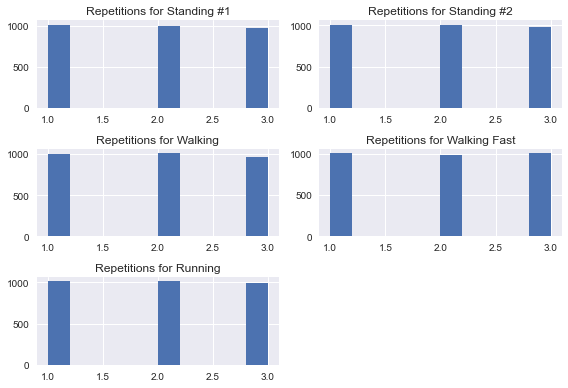

In [257]:
fig, axs = plt.subplots(3, 2)

axs[0,0].hist(df_0['repetition'])
axs[0,0].set_title('Repetitions for Standing #1')

axs[0,1].hist(df_1['repetition'])
axs[0,1].set_title('Repetitions for Standing #2')

axs[1,0].hist(df_2['repetition'])
axs[1,0].set_title('Repetitions for Walking')

axs[1,1].hist(df_3['repetition'])
axs[1,1].set_title('Repetitions for Walking Fast')

axs[2,0].hist(df_4['repetition'])
axs[2,0].set_title('Repetitions for Running')

axs[2,1].axis('off')
# _ = plt.hist(df_0['repetition'])

plt.tight_layout()
plt.show()

The repetitions also seem evenly split for each whole body movement.

In [7]:
df_0.describe()

timestamp     channel_0     channel_1   channel_0_hp   channel_1_hp  \
count  2.982000e+03  2.982000e+03  2.982000e+03    2982.000000    2982.000000   
mean   1.551737e+06  1.252334e+07  1.251100e+07      55.365191     -22.242790   
std    2.926997e+04  4.625126e+05  6.476465e+05   31789.264383   51068.862275   
min    1.514825e+06  1.040201e+07  1.044034e+07 -422438.000000 -702455.000000   
25%    1.517059e+06  1.247265e+07  1.233191e+07   -7547.750000   -9733.000000   
50%    1.552361e+06  1.255198e+07  1.252325e+07     519.000000     721.000000   
75%    1.587323e+06  1.265433e+07  1.264396e+07    8117.250000   11544.250000   
max    1.589687e+06  1.419352e+07  1.494834e+07  275168.000000  465110.000000   

               q_x          q_y          q_z          q_w          g_x  \
count  2982.000000  2982.000000  2982.000000  2982.000000  2982.000000   
mean      0.269799     0.030627     0.056831     0.439367     9.608796   
std       0.308342     0.432441     0.579985     0.334389   106.569236   
min      -0.461182    -0.687683    -0.826233     0.000000  -316.637500   
25%       0.129547    -0.495285    -0.622681     0.118073   -25.458573   
50%       0.316040     0.106445     0.000366     0.373474     0.111906   
75%       0.541138     0.339355     0.715683     0.774658    42.076588   
max       0.720642     0.685486     0.883179     0.995605   321.449460   

               g_y          g_z          a_x          a_y          a_z  \
count  2982.000000  2982.000000  2982.000000  2982.000000  2982.000000   
mean     -2.681105     0.983529     1.615516   -11.144016     1.337795   
std     300.818779    99.780761     5.635892     4.367962     4.913575   
min   -1396.360800  -267.063230   -18.832031   -22.109375   -24.625000   
25%     -46.021268   -34.676816    -1.324219   -13.640625    -0.226562   
50%       1.007152     0.839294    -0.328125    -9.968750     1.027344   
75%      36.719098    39.055130     4.451172    -9.468750     2.906250   
max    1593.818600   242.555860    24.128906    -1.230469    17.507812   

       body_movement   repetition  
count         2982.0  2982.000000  
mean             0.0     1.984239  
std              0.0     0.815042  
min              0.0     1.000000  
25%              0.0     1.000000  
50%              0.0     2.000000  
75%              0.0     3.000000  
max              0.0     3.000000

### Clustering within Body Movement subsets

Make a PCA plot. 

Try for one body movement label at a time.

Investigate each cluster further to see if you can identify the movement.

Can also try k-means clustering or hierarchical clustering afterwards.

In [8]:
# do RMS(?) on accelerometer data

# try a rolling mean

In [169]:
df.describe()

timestamp     channel_0     channel_1   channel_0_hp  channel_1_hp  \
count  1.498100e+04  1.498100e+04  1.498100e+04   14981.000000  1.498100e+04   
mean   1.566353e+06  1.253765e+07  1.251263e+07      62.550898 -2.571735e+02   
std    3.096750e+04  4.158465e+05  5.626673e+05   35397.290087  6.523863e+04   
min    1.514825e+06  1.040201e+07  1.021268e+07 -422438.000000 -1.053204e+06   
25%    1.538782e+06  1.245908e+07  1.233564e+07   -9221.000000 -1.041900e+04   
50%    1.566517e+06  1.256078e+07  1.254805e+07     411.000000  3.980000e+02   
75%    1.594422e+06  1.265877e+07  1.269320e+07    9792.000000  1.127500e+04   
max    1.618179e+06  1.419352e+07  1.504110e+07  640848.000000  1.726175e+06   

                q_x           q_y           q_z           q_w           g_x  \
count  14981.000000  14981.000000  14981.000000  14981.000000  14981.000000   
mean       0.263423      0.051271      0.111606      0.444427      6.407260   
std        0.320534      0.395624      0.588643      0.335159    119.806613   
min       -0.897766     -0.777832     -1.000000      0.000000   -481.754550   
25%        0.032471     -0.085632     -0.304993      0.107849    -36.425343   
50%        0.230042      0.072815      0.036194      0.401611     -0.671435   
75%        0.584961      0.329468      0.712097      0.754333     47.727833   
max        0.905945      0.738708      1.000000      0.999268    427.312380   

                g_y           g_z           a_x           a_y           a_z  \
count  14981.000000  14981.000000  14981.000000  14981.000000  14981.000000   
mean       5.183960      2.237941      0.564972    -10.547218      2.064593   
std      346.986960    110.392775      7.242565      6.138921      6.852529   
min    -1830.891100   -623.763060    -34.382812    -48.960938    -27.765625   
25%      -50.077854    -21.709728     -2.011719    -13.261719     -0.542969   
50%       -0.727388      1.678587     -0.363281     -9.816406      1.457031   
75%       50.413570     39.278942      3.582031     -7.398438      5.097656   
max     1828.317300    425.130220     37.671875      7.691406     33.898438   

       body_movement    repetition  
count   14981.000000  14981.000000  
mean        2.003071      1.991456  
std         1.414352      0.815279  
min         0.000000      1.000000  
25%         1.000000      1.000000  
50%         2.000000      2.000000  
75%         3.000000      3.000000  
max         4.000000      3.000000

In [9]:
df_0['a_x']

0       -0.660156
1       -0.660156
2       -0.660156
3       -0.660156
4       -0.660156
           ...   
11028    1.207031
11029    0.441406
11030    0.441406
11031    0.441406
11032    0.441406
Name: a_x, Length: 2982, dtype: float64

In [17]:
# do a rolling standard deviation on the accelerometer data
# window size: 100, 150

a_X = np.array(df_0['a_x'].rolling(150).std())
a_Y = np.array(df_0['a_y'].rolling(150).std())
a_Z = np.array(df_0['a_z'].rolling(150).std())

In [23]:
# plot scatter of accelerometer data

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# xs = df_0['a_x']
# ys = df_0['a_y']
# zs = df_0['a_z']

xs = a_X
ys = a_Y
zs = a_Z

ax.scatter(xs, ys, zs, marker='o')

ax.set_xlabel('Accelerometer X')
ax.set_ylabel('Accelerometer Y')
ax.set_zlabel('Accelerometer Z')

plt.show()

In [20]:
# do a rolling standard deviation on the gyroscope data
# window size: 100, 150

g_X = np.array(df_0['g_x'].rolling(150).std())
g_Y = np.array(df_0['g_y'].rolling(150).std())
g_Z = np.array(df_0['g_z'].rolling(150).std())

In [24]:
# plot scatter for gyroscope

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = df_0['g_x']
ys = df_0['g_y']
zs = df_0['g_z']

_ = ax.scatter(xs, ys, zs)

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

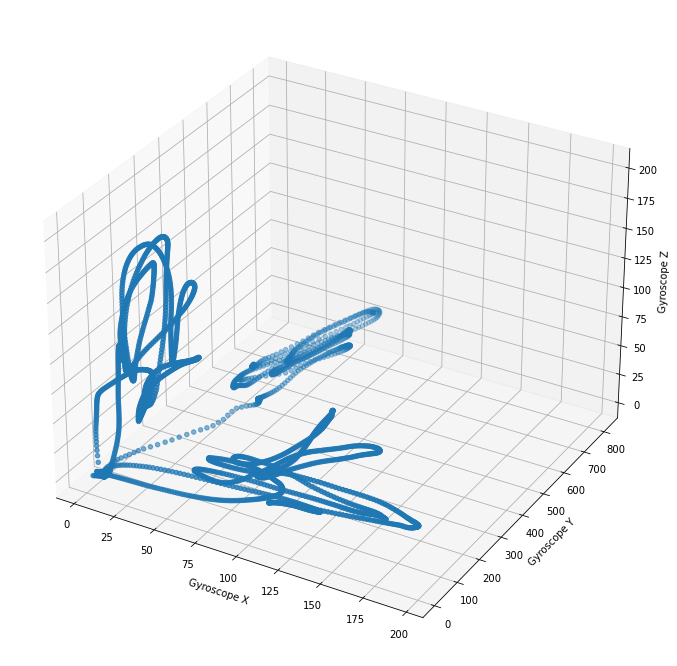

In [25]:
# rolling std on gyroscope

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

xs = g_X
ys = g_Y
zs = g_Z

_ = ax.scatter(xs, ys, zs)

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

In [260]:
# rolling std on gyroscope

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

_ = ax.scatter(xs, ys, zs, c=df['body_movement'], cmap='RdYlBu')

ax.set_xlabel('Gyroscope X')
ax.set_ylabel('Gyroscope Y')
ax.set_zlabel('Gyroscope Z')

plt.show()

In [82]:
# do a rolling standard deviation on the gyroscope data
# window size: 100, 150

g_X = np.array(df['g_x'].rolling(150).std())
g_Y = np.array(df['g_y'].rolling(150).std())
g_Z = np.array(df['g_z'].rolling(150).std())

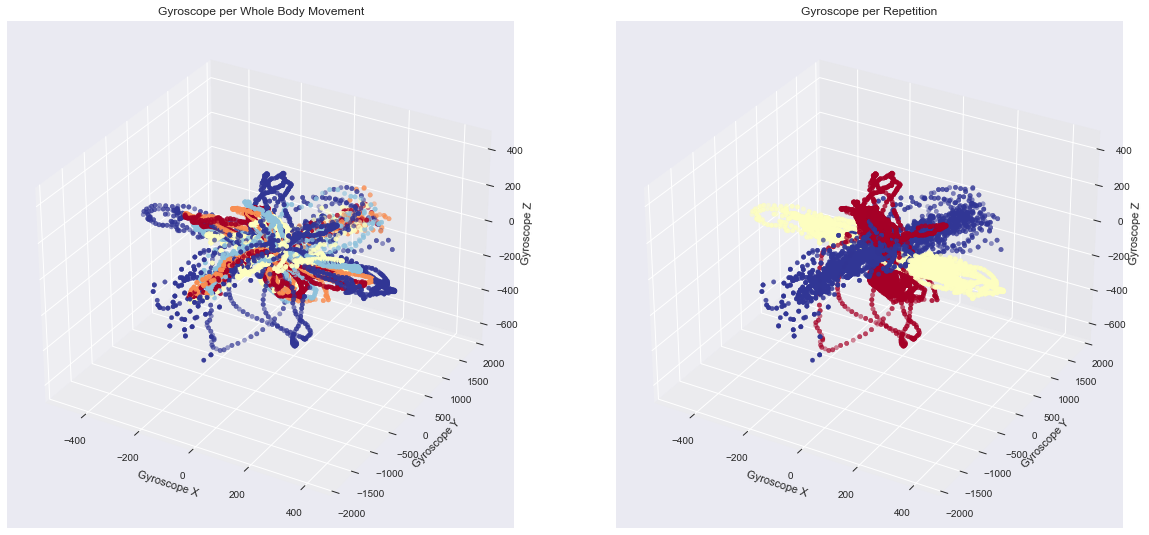

In [261]:
# plot scatter for gyroscope
# fig, axs = plt.subplots(1, 2)
# axs[0] = fig.add_subplot(projection='3d')
# axs[1] = fig.add_subplot(projection='3d')

fig = plt.figure(figsize=[20, 20])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

ax1.scatter(xs, ys, zs, c=df['body_movement'], cmap='RdYlBu')
ax2.scatter(xs, ys, zs, c=df['repetition'], cmap='RdYlBu')

ax1.set_xlabel('Gyroscope X')
ax1.set_ylabel('Gyroscope Y')
ax1.set_zlabel('Gyroscope Z')
ax1.set_title('Gyroscope per Whole Body Movement')

ax2.set_xlabel('Gyroscope X')
ax2.set_ylabel('Gyroscope Y')
ax2.set_zlabel('Gyroscope Z')
ax2.set_title('Gyroscope per Repetition')

plt.show()

In [167]:
import matplotlib as mpl

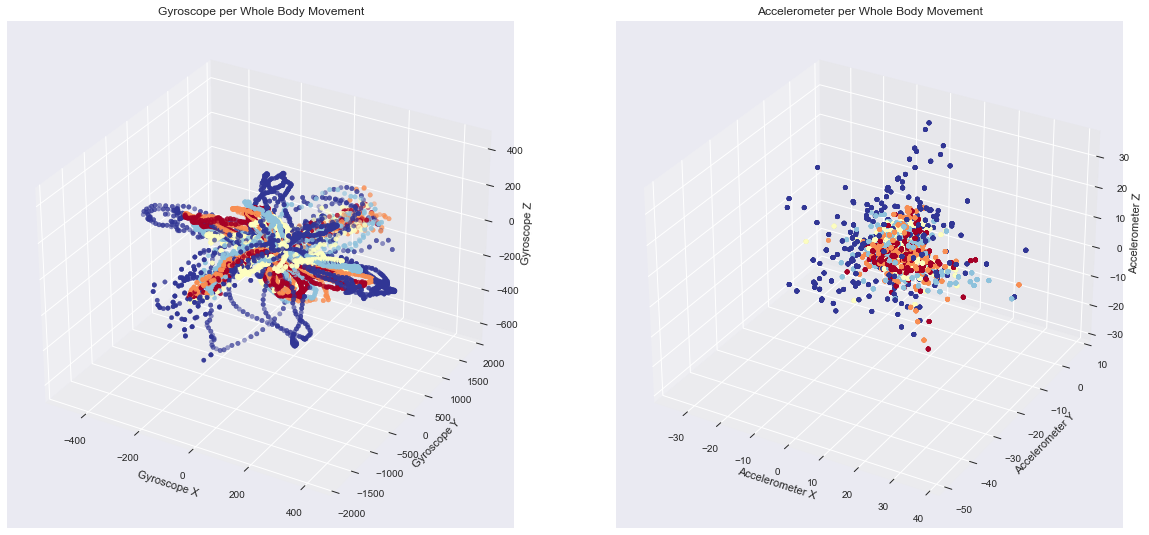

In [262]:
# plot scatter for gyroscope vs accelerometer

fig = plt.figure(figsize=[20, 20])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

Xs = df['a_x']
Ys = df['a_y']
Zs = df['a_z']

ax1.scatter(xs, ys, zs, c=df['body_movement'], cmap='RdYlBu')
ax2.scatter(Xs, Ys, Zs, c=df['body_movement'], cmap='RdYlBu')

ax1.set_xlabel('Gyroscope X')
ax1.set_ylabel('Gyroscope Y')
ax1.set_zlabel('Gyroscope Z')
ax1.set_title('Gyroscope per Whole Body Movement')

ax2.set_xlabel('Accelerometer X')
ax2.set_ylabel('Accelerometer Y')
ax2.set_zlabel('Accelerometer Z')
ax2.set_title('Accelerometer per Whole Body Movement')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

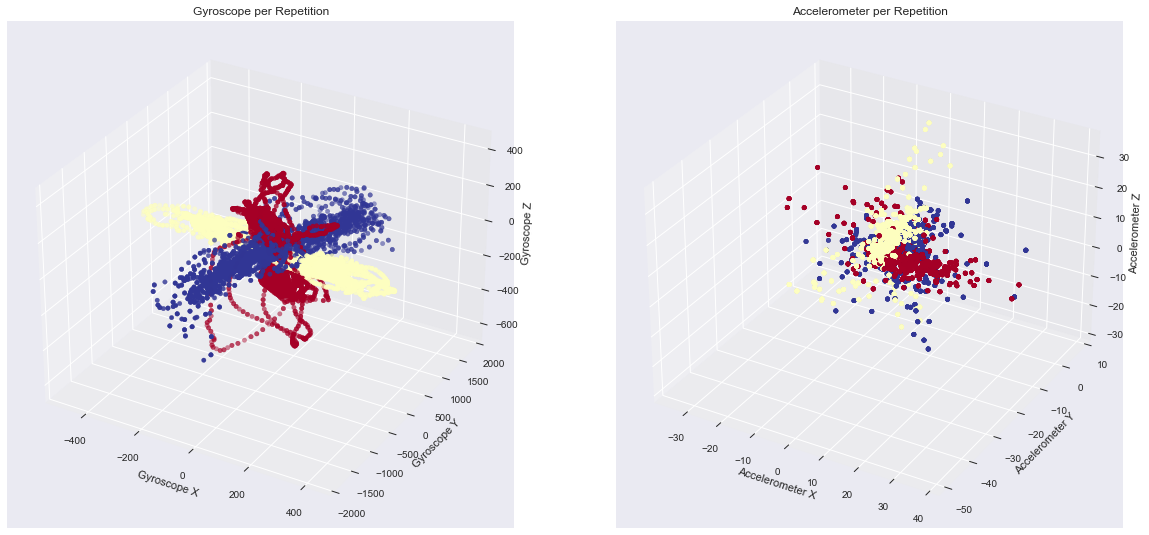

In [263]:
# plot scatter for gyroscope vs accelerometer

fig = plt.figure(figsize=[20, 20])
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

xs = df['g_x']
ys = df['g_y']
zs = df['g_z']

Xs = df['a_x']
Ys = df['a_y']
Zs = df['a_z']

ax1.scatter(xs, ys, zs, c=df['repetition'], cmap='RdYlBu')
ax2.scatter(Xs, Ys, Zs, c=df['repetition'], cmap='RdYlBu')

ax1.set_xlabel('Gyroscope X')
ax1.set_ylabel('Gyroscope Y')
ax1.set_zlabel('Gyroscope Z')
ax1.set_title('Gyroscope per Repetition')

ax2.set_xlabel('Accelerometer X')
ax2.set_ylabel('Accelerometer Y')
ax2.set_zlabel('Accelerometer Z')
ax2.set_title('Accelerometer per Repetition')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

In [311]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig = plt.figure(figsize=[5, 20])

ax1.scatter(df['timestamp'], df['channel_0'], c=df['q_w'], cmap='RdYlBu')
ax1.set_title('Channel 0 vs Time')
ax1.set_xlabel('timestamp')
ax1.set_ylabel('Channel 0 raw')

ax2.scatter(df['timestamp'], df['channel_1'], c=df['q_w'], cmap='RdYlBu')
ax2.set_title('Channel 1 vs Time')
ax1.set_xlabel('timestamp')
ax1.set_ylabel('Channel 1 raw')

plt.show()

<Figure size 360x1440 with 0 Axes>

### Standing Position 1

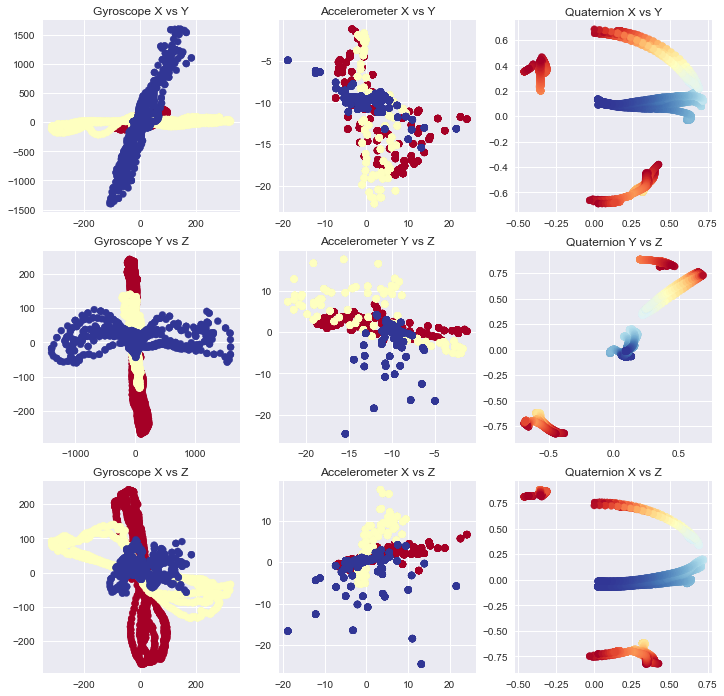

<Figure size 864x864 with 0 Axes>

In [269]:
# now check each body movement subset
# plot gyroscope dimensions against each other 

X = df_0['g_x']
Y = df_0['g_y']
Z = df_0['g_z']

x = df_0['a_x']
y = df_0['a_y']
z = df_0['a_z']

q_x = df_0['q_x']
q_y = df_0['q_y']
q_z = df_0['q_z']
q_w = df_0['q_w']

fig, axs = plt.subplots(3, 3)
fig = plt.figure()

axs[0,0].scatter(X, Y, c=df_0['repetition'], cmap='RdYlBu')
axs[0,0].set_title('Gyroscope X vs Y')

axs[0,1].scatter(x, y, c=df_0['repetition'], cmap='RdYlBu')
axs[0,1].set_title('Accelerometer X vs Y')

# plot quat here
axs[0,2].scatter(q_x, q_y, c=q_w, cmap='RdYlBu')
axs[0,2].set_title('Quaternion X vs Y')

axs[1,0].scatter(Y, Z, c=df_0['repetition'], cmap='RdYlBu')
axs[1,0].set_title('Gyroscope Y vs Z')

axs[1,1].scatter(y, z, c=df_0['repetition'], cmap='RdYlBu')
axs[1,1].set_title('Accelerometer Y vs Z')

# plot quat here
axs[1,2].scatter(q_y, q_z, c=q_w, cmap='RdYlBu')
axs[1,2].set_title('Quaternion Y vs Z')

axs[2,0].scatter(X, Z, c=df_0['repetition'], cmap='RdYlBu')
axs[2,0].set_title('Gyroscope X vs Z')

axs[2,1].scatter(x, z, c=df_0['repetition'], cmap='RdYlBu')
axs[2,1].set_title('Accelerometer X vs Z')

# plot quat here
axs[2,2].scatter(q_x, q_z, c=q_w, cmap='RdYlBu')
axs[2,2].set_title('Quaternion X vs Z')

# axs[1,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

plt.suptitle('Standing #1 Position')
plt.show()

In [206]:
import matplotlib.colors as colors

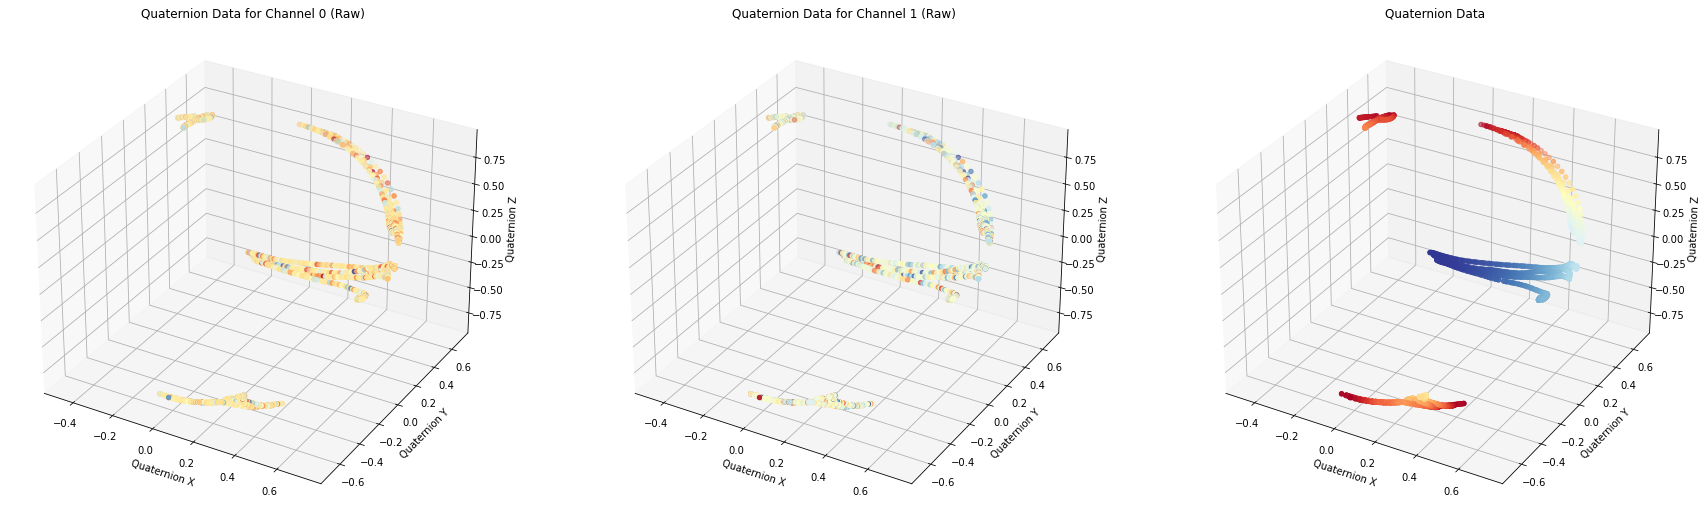

In [250]:
# plot 3D scatter for quaternions
# color by channel 0_hp and channel 1_hp and q_w

fig = plt.figure(figsize=[30, 30])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

q_x, q_y, q_z, q_w = df_0.sample(frac=1)[['q_x','q_y','q_z','q_w']].T.to_numpy()

ax1.scatter(q_x, q_y, q_z, c=df_0['channel_0'], cmap='RdYlBu_r', vmin=min(df_0['channel_0']), vmax=max(df_0['channel_0']))
ax2.scatter(q_x, q_y, q_z, c=df_0['channel_1'], cmap='RdYlBu_r', vmin=min(df_0['channel_1']), vmax=max(df_0['channel_1']))
ax3.scatter(q_x, q_y, q_z, c=q_w, cmap='RdYlBu')

ax1.set_xlabel('Quaternion X')
ax1.set_ylabel('Quaternion Y')
ax1.set_zlabel('Quaternion Z')
ax1.set_title('Quaternion Data for Channel 0 (Raw)')

ax2.set_xlabel('Quaternion X')
ax2.set_ylabel('Quaternion Y')
ax2.set_zlabel('Quaternion Z')
ax2.set_title('Quaternion Data for Channel 1 (Raw)')

ax3.set_xlabel('Quaternion X')
ax3.set_ylabel('Quaternion Y')
ax3.set_zlabel('Quaternion Z')
ax3.set_title('Quaternion Data')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

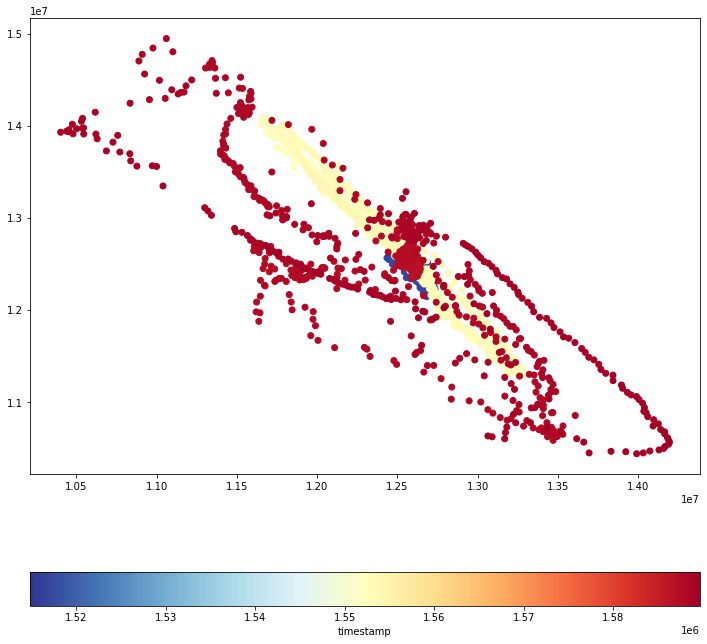

In [247]:
plt.scatter(x=df_0['channel_0'], y=df_0['channel_1'], c=df_0['timestamp'], vmin=min(df_0['timestamp']), vmax=max(df_0['timestamp']), cmap='RdYlBu_r')
plt.colorbar(label='timestamp', orientation='horizontal')
plt.show()

### Standing Position 2

In [274]:
df.columns

Index(['timestamp', 'channel_0', 'channel_1', 'channel_0_hp', 'channel_1_hp',
       'q_x', 'q_y', 'q_z', 'q_w', 'g_x', 'g_y', 'g_z', 'a_x', 'a_y', 'a_z',
       'body_movement', 'repetition'],
      dtype='object')

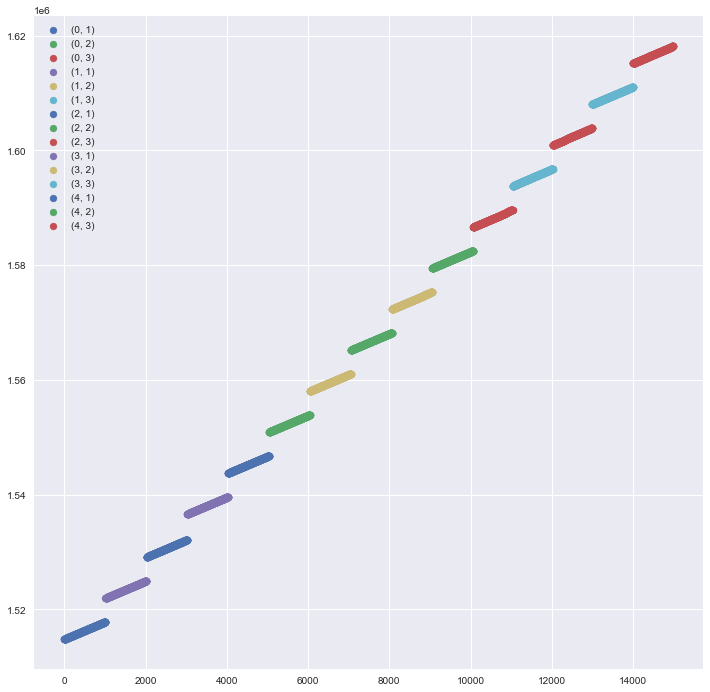

In [275]:
for label, group in df.groupby(['body_movement','repetition']):
    plt.scatter(group.index,group['timestamp'],label=label)
    
plt.legend()

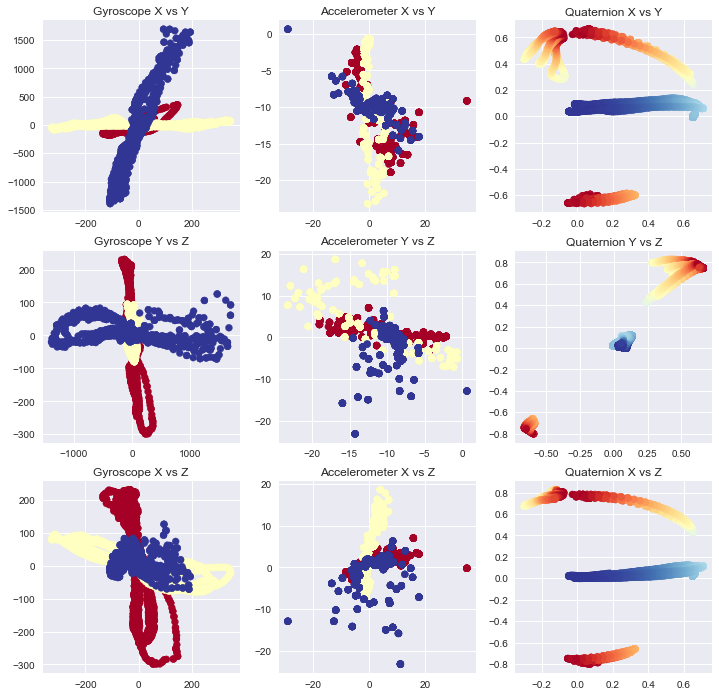

<Figure size 864x864 with 0 Axes>

In [282]:
# plot gyroscope and accelerometer dimensions next to each other 

X = df_1['g_x']
Y = df_1['g_y']
Z = df_1['g_z']

x = df_1['a_x']
y = df_1['a_y']
z = df_1['a_z']

q_x = df_1['q_x']
q_y = df_1['q_y']
q_z = df_1['q_z']
q_w = df_1['q_w']

fig, axs = plt.subplots(3, 3)
fig = plt.figure()

axs[0,0].scatter(X, Y, c=df_1['repetition'], cmap='RdYlBu')
axs[0,0].set_title('Gyroscope X vs Y')

axs[0,1].scatter(x, y, c=df_1['repetition'], cmap='RdYlBu')
axs[0,1].set_title('Accelerometer X vs Y')

# plot quat here
axs[0,2].scatter(q_x, q_y, c=q_w, cmap='RdYlBu')
axs[0,2].set_title('Quaternion X vs Y')

axs[1,0].scatter(Y, Z, c=df_1['repetition'], cmap='RdYlBu')
axs[1,0].set_title('Gyroscope Y vs Z')

axs[1,1].scatter(y, z, c=df_1['repetition'], cmap='RdYlBu')
axs[1,1].set_title('Accelerometer Y vs Z')

# plot quat here
axs[1,2].scatter(q_y, q_z, c=q_w, cmap='RdYlBu')
axs[1,2].set_title('Quaternion Y vs Z')

axs[2,0].scatter(X, Z, c=df_1['repetition'], cmap='RdYlBu')
axs[2,0].set_title('Gyroscope X vs Z')

axs[2,1].scatter(x, z, c=df_1['repetition'], cmap='RdYlBu')
axs[2,1].set_title('Accelerometer X vs Z')

# plot quat here
axs[2,2].scatter(q_x, q_z, c=q_w, cmap='RdYlBu')
axs[2,2].set_title('Quaternion X vs Z')

# axs[1,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

fig.suptitle('Standing #2 Position')
plt.show()

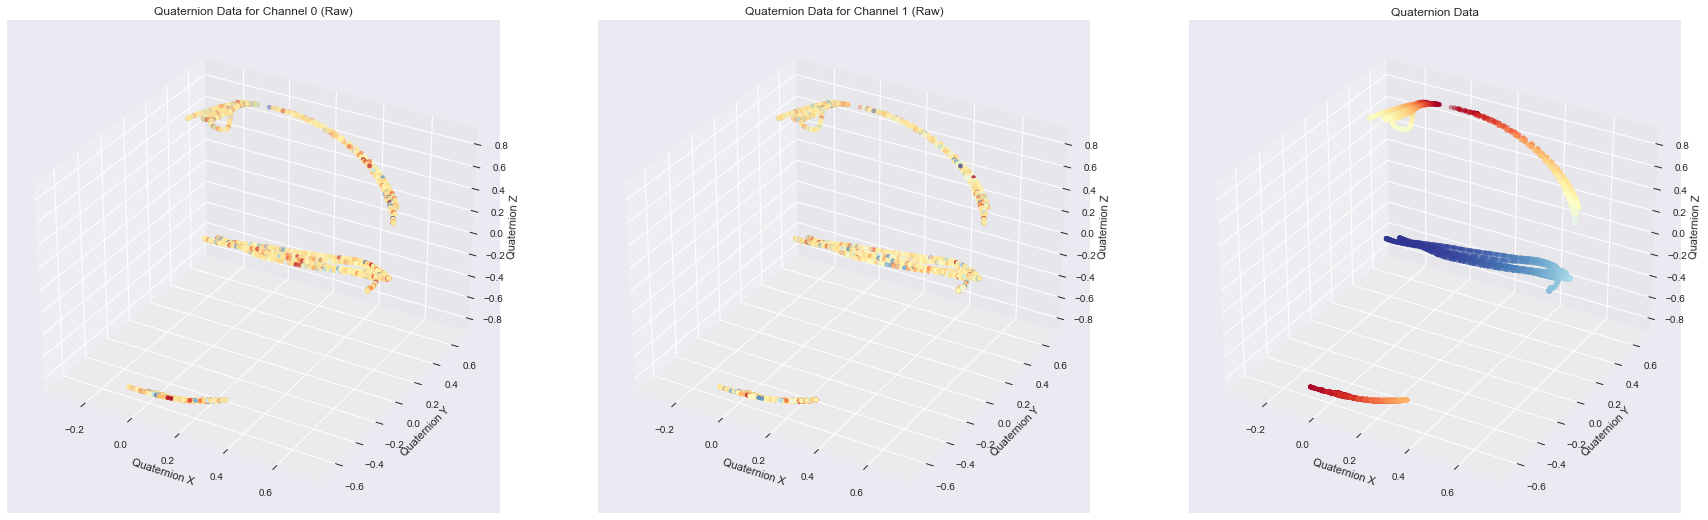

In [283]:
# plot 3D scatter for quaternions
# color by channel 0_hp and channel 1_hp and q_w

fig = plt.figure(figsize=[30, 30])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

q_x, q_y, q_z, q_w = df_1.sample(frac=1)[['q_x','q_y','q_z','q_w']].T.to_numpy()

ax1.scatter(q_x, q_y, q_z, c=df_1['channel_0'], cmap='RdYlBu_r', vmin=min(df_1['channel_0']), vmax=max(df_1['channel_0']))
ax2.scatter(q_x, q_y, q_z, c=df_1['channel_1'], cmap='RdYlBu_r', vmin=min(df_1['channel_1']), vmax=max(df_1['channel_1']))
ax3.scatter(q_x, q_y, q_z, c=q_w, cmap='RdYlBu')

ax1.set_xlabel('Quaternion X')
ax1.set_ylabel('Quaternion Y')
ax1.set_zlabel('Quaternion Z')
ax1.set_title('Quaternion Data for Channel 0 (Raw)')

ax2.set_xlabel('Quaternion X')
ax2.set_ylabel('Quaternion Y')
ax2.set_zlabel('Quaternion Z')
ax2.set_title('Quaternion Data for Channel 1 (Raw)')

ax3.set_xlabel('Quaternion X')
ax3.set_ylabel('Quaternion Y')
ax3.set_zlabel('Quaternion Z')
ax3.set_title('Quaternion Data')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

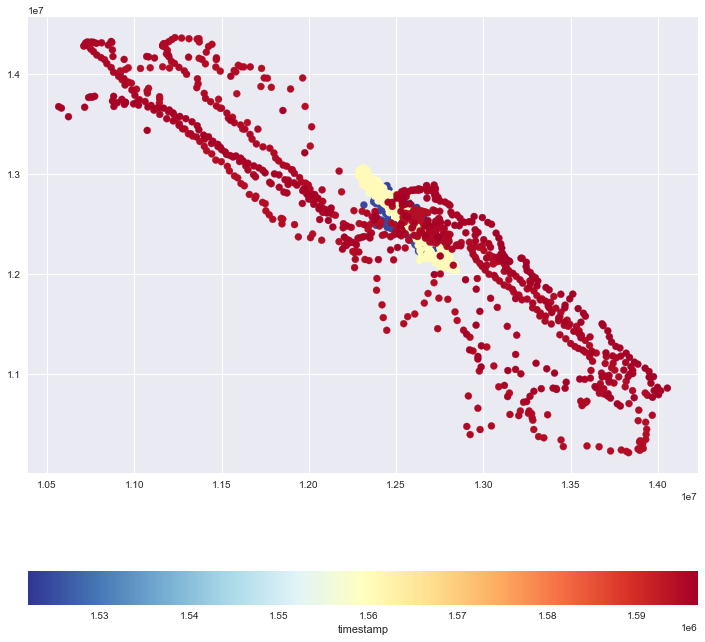

In [285]:
plt.scatter(x=df_1['channel_0'], y=df_1['channel_1'], c=df_1['timestamp'], vmin=min(df_1['timestamp']), vmax=max(df_1['timestamp']), cmap='RdYlBu_r')
plt.colorbar(label='timestamp', orientation='horizontal')
plt.show()

### Walking

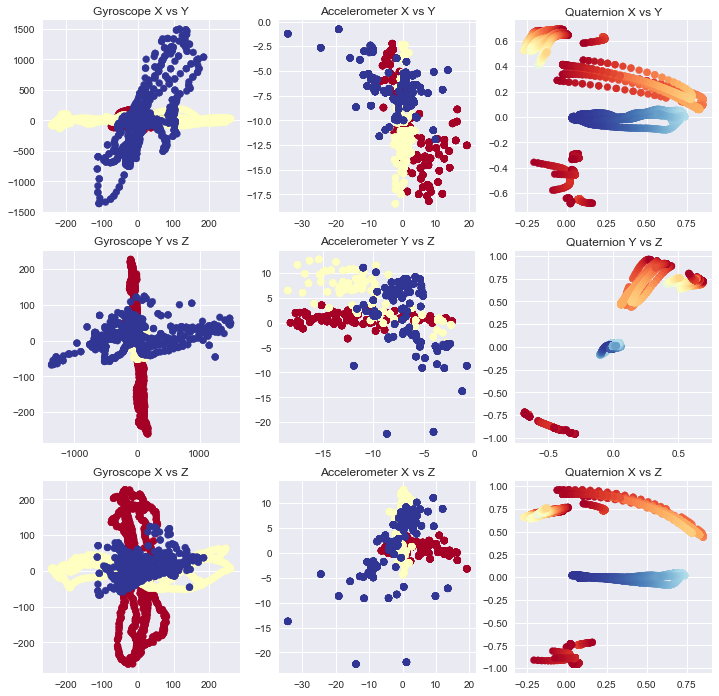

<Figure size 864x864 with 0 Axes>

In [319]:
# plot gyroscope and accelerometer dimensions next to each other 

X = df_2['g_x']
Y = df_2['g_y']
Z = df_2['g_z']

x = df_2['a_x']
y = df_2['a_y']
z = df_2['a_z']

q_x = df_2['q_x']
q_y = df_2['q_y']
q_z = df_2['q_z']
q_w = df_2['q_w']

fig, axs = plt.subplots(3, 3)
fig = plt.figure()

axs[0,0].scatter(X, Y, c=df_2['repetition'], cmap='RdYlBu')
axs[0,0].set_title('Gyroscope X vs Y')

axs[0,1].scatter(x, y, c=df_2['repetition'], cmap='RdYlBu')
axs[0,1].set_title('Accelerometer X vs Y')

# plot quat here
axs[0,2].scatter(q_x, q_y, c=q_w, cmap='RdYlBu')
axs[0,2].set_title('Quaternion X vs Y')

axs[1,0].scatter(Y, Z, c=df_2['repetition'], cmap='RdYlBu')
axs[1,0].set_title('Gyroscope Y vs Z')

axs[1,1].scatter(y, z, c=df_2['repetition'], cmap='RdYlBu')
axs[1,1].set_title('Accelerometer Y vs Z')

# plot quat here
axs[1,2].scatter(q_y, q_z, c=q_w, cmap='RdYlBu')
axs[1,2].set_title('Quaternion Y vs Z')

axs[2,0].scatter(X, Z, c=df_2['repetition'], cmap='RdYlBu')
axs[2,0].set_title('Gyroscope X vs Z')

axs[2,1].scatter(x, z, c=df_2['repetition'], cmap='RdYlBu')
axs[2,1].set_title('Accelerometer X vs Z')

# plot quat here
axs[2,2].scatter(q_x, q_z, c=q_w, cmap='RdYlBu')
axs[2,2].set_title('Quaternion X vs Z')

# axs[1,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

fig.suptitle('Walking Position')
plt.show()

In [318]:
# plot 3D scatter for quaternions
# color by channel 0_hp and channel 1_hp and q_w

fig = plt.figure(figsize=[30, 30])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

q_x, q_y, q_z, q_w = df_2.sample(frac=1)[['q_x','q_y','q_z','q_w']].T.to_numpy()

ax1.scatter(q_x, q_y, q_z, c=df_2['channel_0'], cmap='RdYlBu_r', vmin=min(df_2['channel_0']), vmax=max(df_2['channel_0']))
ax2.scatter(q_x, q_y, q_z, c=df_2['channel_1'], cmap='RdYlBu_r', vmin=min(df_2['channel_1']), vmax=max(df_2['channel_1']))
ax3.scatter(q_x, q_y, q_z, c=q_w, cmap='RdYlBu')

ax1.set_xlabel('Quaternion X')
ax1.set_ylabel('Quaternion Y')
ax1.set_zlabel('Quaternion Z')
ax1.set_title('Quaternion Data for Channel 0 (Raw)')

ax2.set_xlabel('Quaternion X')
ax2.set_ylabel('Quaternion Y')
ax2.set_zlabel('Quaternion Z')
ax2.set_title('Quaternion Data for Channel 1 (Raw)')

ax3.set_xlabel('Quaternion X')
ax3.set_ylabel('Quaternion Y')
ax3.set_zlabel('Quaternion Z')
ax3.set_title('Quaternion Data')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

### Walking Fast

In [321]:
# plot gyroscope and accelerometer dimensions next to each other 

X = df_3['g_x']
Y = df_3['g_y']
Z = df_3['g_z']

x = df_3['a_x']
y = df_3['a_y']
z = df_3['a_z']

q_x = df_3['q_x']
q_y = df_3['q_y']
q_z = df_3['q_z']
q_w = df_3['q_w']

fig, axs = plt.subplots(3, 3)
fig = plt.figure()

axs[0,0].scatter(X, Y, c=df_3['repetition'], cmap='RdYlBu')
axs[0,0].set_title('Gyroscope X vs Y')

axs[0,1].scatter(x, y, c=df_3['repetition'], cmap='RdYlBu')
axs[0,1].set_title('Accelerometer X vs Y')

# plot quat here
axs[0,2].scatter(q_x, q_y, c=q_w, cmap='RdYlBu')
axs[0,2].set_title('Quaternion X vs Y')

axs[1,0].scatter(Y, Z, c=df_3['repetition'], cmap='RdYlBu')
axs[1,0].set_title('Gyroscope Y vs Z')

axs[1,1].scatter(y, z, c=df_3['repetition'], cmap='RdYlBu')
axs[1,1].set_title('Accelerometer Y vs Z')

# plot quat here
axs[1,2].scatter(q_y, q_z, c=q_w, cmap='RdYlBu')
axs[1,2].set_title('Quaternion Y vs Z')

axs[2,0].scatter(X, Z, c=df_3['repetition'], cmap='RdYlBu')
axs[2,0].set_title('Gyroscope X vs Z')

axs[2,1].scatter(x, z, c=df_3['repetition'], cmap='RdYlBu')
axs[2,1].set_title('Accelerometer X vs Z')

# plot quat here
axs[2,2].scatter(q_x, q_z, c=q_w, cmap='RdYlBu')
axs[2,2].set_title('Quaternion X vs Z')

# axs[1,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

fig.suptitle('Walking Fast Position')
plt.show()

<Figure size 864x864 with 0 Axes>

In [322]:
# plot 3D scatter for quaternions
# color by channel 0_hp and channel 1_hp and q_w

fig = plt.figure(figsize=[30, 30])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

q_x, q_y, q_z, q_w = df_3.sample(frac=1)[['q_x','q_y','q_z','q_w']].T.to_numpy()

ax1.scatter(q_x, q_y, q_z, c=df_3['channel_0'], cmap='RdYlBu_r', vmin=min(df_3['channel_0']), vmax=max(df_3['channel_0']))
ax2.scatter(q_x, q_y, q_z, c=df_3['channel_1'], cmap='RdYlBu_r', vmin=min(df_3['channel_1']), vmax=max(df_3['channel_1']))
ax3.scatter(q_x, q_y, q_z, c=q_w, cmap='RdYlBu')

ax1.set_xlabel('Quaternion X')
ax1.set_ylabel('Quaternion Y')
ax1.set_zlabel('Quaternion Z')
ax1.set_title('Quaternion Data for Channel 0 (Raw)')

ax2.set_xlabel('Quaternion X')
ax2.set_ylabel('Quaternion Y')
ax2.set_zlabel('Quaternion Z')
ax2.set_title('Quaternion Data for Channel 1 (Raw)')

ax3.set_xlabel('Quaternion X')
ax3.set_ylabel('Quaternion Y')
ax3.set_zlabel('Quaternion Z')
ax3.set_title('Quaternion Data')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

Much noisier data compared to standing positions! 

Wrist naturally swings back and forth while walking, which is very visibly present in the quaternion visualizations for this body movement.

### Running

Expect this subset to be the noisiest, since arm/wrist moves back and forth in fixed orientation while running (assuming proper running form).

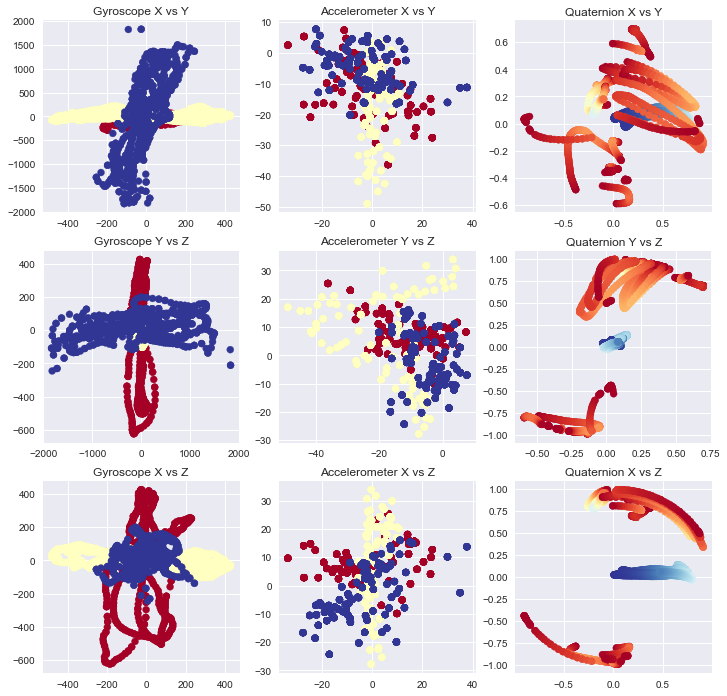

<Figure size 864x864 with 0 Axes>

In [323]:
# plot gyroscope and accelerometer dimensions next to each other 

X = df_4['g_x']
Y = df_4['g_y']
Z = df_4['g_z']

x = df_4['a_x']
y = df_4['a_y']
z = df_4['a_z']

q_x = df_4['q_x']
q_y = df_4['q_y']
q_z = df_4['q_z']
q_w = df_4['q_w']

fig, axs = plt.subplots(3, 3)
fig = plt.figure()

axs[0,0].scatter(X, Y, c=df_4['repetition'], cmap='RdYlBu')
axs[0,0].set_title('Gyroscope X vs Y')

axs[0,1].scatter(x, y, c=df_4['repetition'], cmap='RdYlBu')
axs[0,1].set_title('Accelerometer X vs Y')

# plot quat here
axs[0,2].scatter(q_x, q_y, c=q_w, cmap='RdYlBu')
axs[0,2].set_title('Quaternion X vs Y')

axs[1,0].scatter(Y, Z, c=df_4['repetition'], cmap='RdYlBu')
axs[1,0].set_title('Gyroscope Y vs Z')

axs[1,1].scatter(y, z, c=df_4['repetition'], cmap='RdYlBu')
axs[1,1].set_title('Accelerometer Y vs Z')

# plot quat here
axs[1,2].scatter(q_y, q_z, c=q_w, cmap='RdYlBu')
axs[1,2].set_title('Quaternion Y vs Z')

axs[2,0].scatter(X, Z, c=df_4['repetition'], cmap='RdYlBu')
axs[2,0].set_title('Gyroscope X vs Z')

axs[2,1].scatter(x, z, c=df_4['repetition'], cmap='RdYlBu')
axs[2,1].set_title('Accelerometer X vs Z')

# plot quat here
axs[2,2].scatter(q_x, q_z, c=q_w, cmap='RdYlBu')
axs[2,2].set_title('Quaternion X vs Z')

# axs[1,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

fig.suptitle('Walking Fast Position')
plt.show()

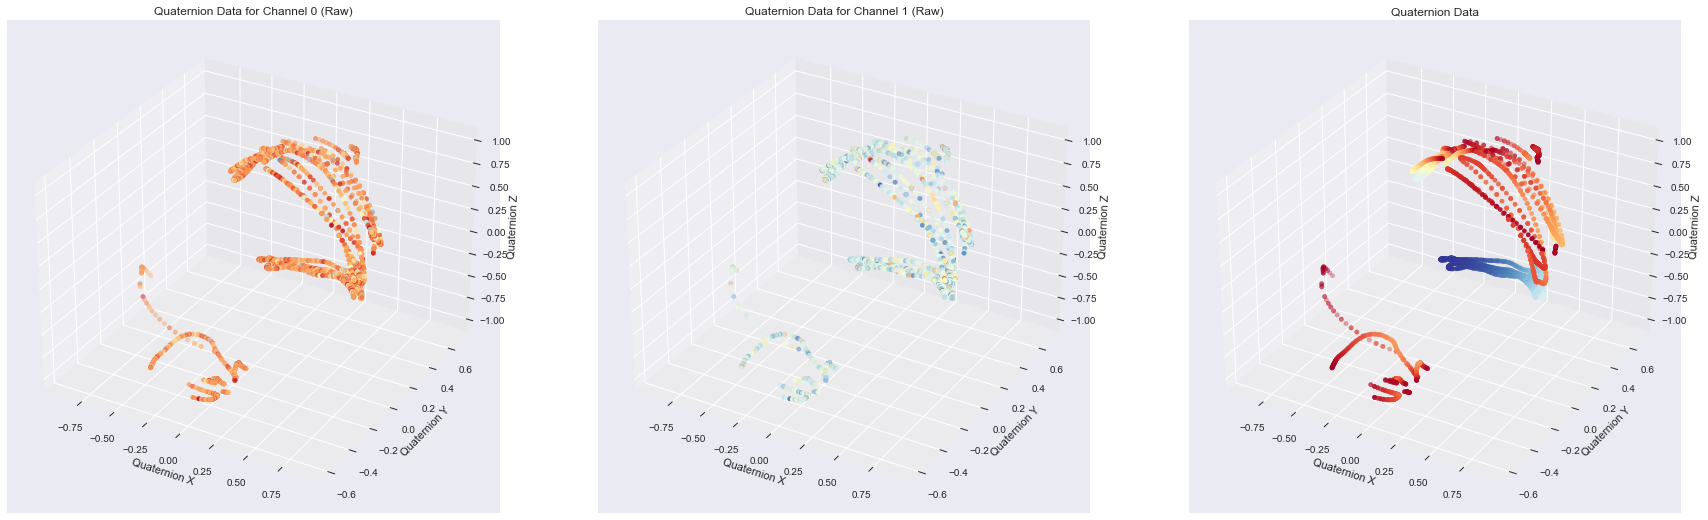

In [324]:
# plot 3D scatter for quaternions
# color by channel 0_hp and channel 1_hp and q_w

fig = plt.figure(figsize=[30, 30])
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

q_x, q_y, q_z, q_w = df_4.sample(frac=1)[['q_x','q_y','q_z','q_w']].T.to_numpy()

ax1.scatter(q_x, q_y, q_z, c=df_4['channel_0'], cmap='RdYlBu_r', vmin=min(df_4['channel_0']), vmax=max(df_4['channel_0']))
ax2.scatter(q_x, q_y, q_z, c=df_4['channel_1'], cmap='RdYlBu_r', vmin=min(df_4['channel_1']), vmax=max(df_4['channel_1']))
ax3.scatter(q_x, q_y, q_z, c=q_w, cmap='RdYlBu')

ax1.set_xlabel('Quaternion X')
ax1.set_ylabel('Quaternion Y')
ax1.set_zlabel('Quaternion Z')
ax1.set_title('Quaternion Data for Channel 0 (Raw)')

ax2.set_xlabel('Quaternion X')
ax2.set_ylabel('Quaternion Y')
ax2.set_zlabel('Quaternion Z')
ax2.set_title('Quaternion Data for Channel 1 (Raw)')

ax3.set_xlabel('Quaternion X')
ax3.set_ylabel('Quaternion Y')
ax3.set_zlabel('Quaternion Z')
ax3.set_title('Quaternion Data')

## want to add a colorbar for each subplot!!
# fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=4), cmap='jet'),
#              cax=ax1, orientation='vertical', label='Body Movement')

# plt.colorbar(ax=ax1, location='left', orientation='vertical')

plt.show()

### Generalizability

Within a body movement and wrist motion class (of which there are decidedly 4 classes of motions), look at the variance between each repetition. Each class has 3 repetitions, or 3 samples. How similar or different were the repetitions?

Can use these to make some quantitative estimates of repetitions. 

Not completely sure, but assume that this data is only from one person for the entire study.

### PCA plots

In [134]:
def plot_pca(df, ax):
    # make a copy of the data
    # cut off the last two cols, which hold the 'labels'
    data = df[1:-2]
    
    # standardize the data
    standardized_data = StandardScaler().fit_transform(data)
    
    # co-variance of matrix
    cov_matrix = np.matmul(standardized_data.T, standardized_data)
    
    values, vectors = eigh(cov_matrix, eigvals=(cov_matrix.shape[0]-2, cov_matrix.shape[0]-1))
    vectors = vectors.T
    
    # projecting original data on plane formed by two principals
    new_coord = np.matmul(vectors, standardized_data.T)
    
    # new dataframe for plotting labeled 2D projection
    pca_df = pd.DataFrame(data=new_coord.T, columns=("1st_Principal", "2nd_Principal"))
    
    scatter = sns.FacetGrid(pca_df, palette='pastel', height=8).map(ax.scatter, '1st_Principal', '2nd_Principal')
    
    ax.set_xlim(min(pca_df["1st_Principal"])-1, max(pca_df["1st_Principal"])+1)
    ax.set_ylim(min(pca_df["2nd_Principal"])-1, max(pca_df["2nd_Principal"])+1)
    
    ax.set_xlabel('1st Principal')
    ax.set_ylabel('2nd Principal')
    
    plt.close()

In [286]:
# PCA plots for each body movement
# color by timestamp to see the movements

fig, axs = plt.subplots(3, 2)
fig = plt.figure()

plot_pca(df_0, axs[0,0])
axs[0,0].set_title('PCA for Standing #1')

plot_pca(df_1, axs[0,1])
axs[0,1].set_title('PCA for Standing #2')

plot_pca(df_2, axs[1,0])
axs[1,0].set_title('PCA for Walking')

plot_pca(df_3, axs[1,1])
axs[1,1].set_title('PCA for Walking Fast')

plot_pca(df_4, axs[2,0])
axs[2,0].set_title('PCA for Running')

plot_pca(df, axs[2,1])
axs[2,1].set_title('PCA for All')
# axs[2,1].axis('off')

# add some padding around plots because titles getting squished
fig.subplots_adjust(bottom=0.8, right=0.8, top=0.9)

plt.show()

<Figure size 864x864 with 0 Axes>

#### Other Clustering Methods